In [369]:
%matplotlib inline
from Simulation import *
import datetime, time
from scipy import ndimage

In [8]:
kwargs = {}
kwargs['size'] = 1000000
kwargs['Bragg_peak_rel'] = 1.39
kwargs['Bloch_peak_rel'] = 0.28
kwargs['xc'] = [0,0]
kwargs['vc'] = [0,0]
kwargs['v_2nd_Bragg'] = 2.0480821101976
kwargs['g'] = 9.79958
kwargs['sigma_x'] = 0.002
kwargs['sigma_v'] = 0.0035
xy_t = MC.MonteCarloCCD(kwargs)

NameError: name 'MC' is not defined

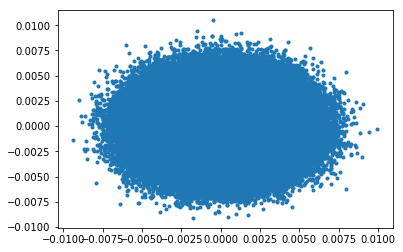

In [10]:
plt.plot(xy_t[:,0], xy_t[:,1],'.')
plt.show()

In [9]:
plt.rc('text', usetex=True)

In [10]:
def xy(xy0, vT, t):
    return xy0+vT*t
def z(z0, v0, t):
    return z0+v0*t-0.5*g*t**2
def v(z0, v0, t):
    return v0-g*t

In [11]:
#Laser
Detuning = 14E+9
fL =  3.517309021e+14+90E+6+80E+6+Detuning
c = 2.99792458e+8
k = 2*np.pi*fL/c
hbar = 1.0545718E-34
#Atom distribution
sigma_x = 0.002
sigma_v = 0.0035
kB = 1.38064852e-23
M = 2.20694650e-25
Temperature = sigma_v**2*M/kB
#Atom Interferometer Parameters
t0 = 1.24-1.12
T = 0.060
Tp1 = 0.005
TB = 0.008
Tp2 = 0.015
ztop = 65*0.0254
vr = hbar*k/M
omega_r = hbar*k**2/2/M
n = 5
N = 125
#Atom trajectory
v_2nd_Bragg = 2.0480821101976
g = 9.79958

# Get Bragg and Bloch efficiency

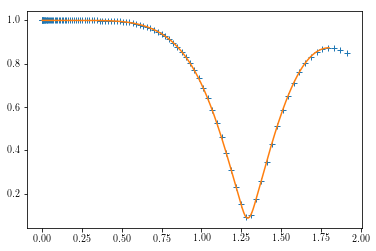

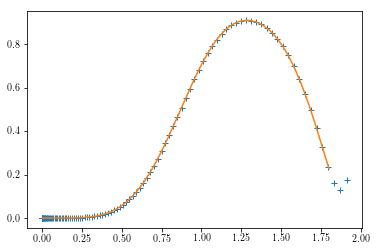

In [12]:
#Read Bragg power efficiency function
Bragg_data_table = np.loadtxt('Bragg_power.txt')
intensity = Bragg_data_table[:,0]
population0 = Bragg_data_table[:,1]
population1 = Bragg_data_table[:,2]
eff0 = interpolate.interp1d(intensity, np.sqrt(population0), kind = 'cubic')
eff1 = interpolate.interp1d(intensity, np.sqrt(population1), kind = 'cubic')
x = np.linspace(0, 1.8, 500)
y = eff0(x)
plt.plot(intensity, np.sqrt(population0), '+', x, y, '-')
plt.show()
x = np.linspace(0, 1.8, 500)
y = eff1(x)
plt.plot(intensity, np.sqrt(population1), '+', x, y, '-')
plt.show()

def contrast_up(intensity):
    if intensity < 0.1 or intensity > 1.25:
        return 0
    eta0, eta1 = eff0(intensity)**2, eff1(intensity)**2
    return (4*eta1**2*eta0**2)/(eta1**3*eta0+eta1*eta0**3+2*eta1**2*eta0**2)
def contrast_down(intensity):
    if intensity < 0.1 or intensity > 1.25:
        return 0
    eta0, eta1 = eff0(intensity)**2, eff1(intensity)**2
    return (4*eta1**2*eta0**2)/(eta1**4+eta0**4+eta1**3*eta0+eta1*eta0**3)

In [6]:
def Raman_eff1(intensity):
    return np.sin(intensity*np.pi/2)
def Raman_eff0(intensity):
    return np.cos(intensity*np.pi/2)

In [13]:
def contrast_up(intensity):
    if intensity < 0.1 or intensity > 1.25:
        return 0
    eta0, eta1 = eff0(intensity)**2, eff1(intensity)**2
    return (4*eta1**2*eta0**2)/(eta1**3*eta0+eta1*eta0**3+2*eta1**2*eta0**2)
def contrast_down(intensity):
    if intensity < 0.1 or intensity > 1.25:
        return 0
    eta0, eta1 = eff0(intensity)**2, eff1(intensity)**2
    return (4*eta1**2*eta0**2)/(eta1**4+eta0**4+eta1**3*eta0+eta1*eta0**3)

In [7]:
I = np.linspace(0.1,1.25,100)
Cup = np.zeros(100)
Cdown = np.zeros(100)
for i in range(100):
    Cup[i] = contrast_up(I[i])
    Cdown[i] = contrast_down(I[i])

In [6]:
def Hermite_Gaussian(x,x0,w,a,c1,c2):
    return a*hermite.hermval((x-x0)*np.sqrt(2)/w,[1,c1,c2])*np.exp(-((x-x0)**2)/w**2)

In [9]:
initial_guess = (1, 0.3, 1, 0, 0)
popt, pcov = curve_fit(Hermite_Gaussian, I, Cdown, p0 = initial_guess)

In [10]:
popt

array([ 0.57622689,  0.16770977,  0.85165993, -0.33685917,  0.04667956])

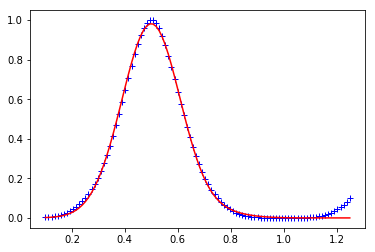

In [11]:
plt.plot(I, Cdown, 'b+', I, Hermite_Gaussian(I, *popt), 'r-')

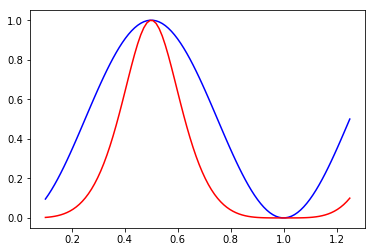

In [12]:
plt.plot(I,Cup,'b',I,Cdown,'r')
plt.show()

In [13]:
special.erf(-3)

-0.99997790950300147

In [14]:
Bloch_Params = [0.194,0.0179,0.215,322];
def Blocheff(intensity, Params = Bloch_Params):
    intensity = intensity*1000
    return Params[0]*special.erf(Params[1]*(intensity-Params[3]))+Params[2]

In [15]:
Bloch_Params = [0.5,0.0179,0,322];
def Blocheff(intensity, Params = Bloch_Params):
    intensity = intensity*1000
    return Params[0]*special.erf(Params[1]*(intensity-Params[3]))+Params[2]

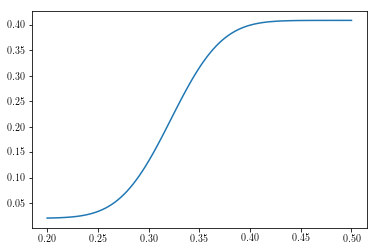

In [15]:
intensity = np.linspace(0.2,0.5,100)
plt.plot(intensity, Blocheff(intensity))
plt.show()

# Prepare Beam Info

In [16]:
def Hermite_Gaussian2D(xyz,x0,y0,z0,w0,a,cx1,cx2,cy1,cy2):
    x = xyz[0]
    y = xyz[1]
    z = xyz[2]
    zr = k*w0**2/2
    w = w0*np.sqrt(1+(z-z0)**2/zr**2)
    return a*hermite.hermval((x-x0)*np.sqrt(2)/w,[1,cx1,cx2])*hermite.hermval((y-y0)*np.sqrt(2)/w,[1,cy1,cy2])*np.exp(-(x-x0)**2/w**2)*np.exp(-(y-y0)**2/w**2)

In [17]:
A0 = 1
z0 = 0.80
w0 = 0.002287
cx = [1, 0.0462, 0.0702]
cy = [1, -0.00228, 0.0745]
#cx = [1, 0, 0]
#cy = [1, 0, 0]
beam_p = np.concatenate([[0,0,z0,w0,1],cx[1:],cy[1:]])                     

In [22]:
Image_list = []
for i in range(10):
    Raw = np.fromfile('CCD/55/DeviceData_tilt_#00{0}.raw'.format(i), dtype='int16', sep="")
    Raw_info = Raw[:27]
    print("Image00{0}".format(i))
    print(Raw_info)
    Raw = Raw[27:]
    Raw=Raw.reshape([1024,1360])
    #plt.imshow(Raw, cmap=plt.cm.jet, origin='bottom')
    #plt.show()
    Image_list.append(Raw)
Image_list = np.array(Image_list)

Image000
[ 19778      0      0 -20726   6449     54      0     40      0   1360
      0  -1024     -1      1     16      0      0      0      0      0
      0      0      0      0      0      0      0]
Image001
[ 19778      0      0 -20726   6449     54      0     40      0   1360
      0  -1024     -1      1     16      0      0      0      0      0
      0      0      0      0      0      0      0]
Image002
[ 19778      0      0 -20726   6449     54      0     40      0   1360
      0  -1024     -1      1     16      0      0      0      0      0
      0      0      0      0      0      0      0]
Image003
[ 19778      0      0 -20726   6449     54      0     40      0   1360
      0  -1024     -1      1     16      0      0      0      0      0
      0      0      0      0      0      0      0]
Image004
[ 19778      0      0 -20726   6449     54      0     40      0   1360
      0  -1024     -1      1     16      0      0      0      0      0
      0      0      0      0      0      

In [23]:
np.shape(Image_list)

(10, 1024, 1360)

In [27]:
Raw = np.zeros(np.array(np.shape(Image_list)[1:]))
for i in range(np.shape(Raw)[0]):
    for j in range(np.shape(Raw)[1]):
        Raw[i,j] = np.mean(Image_list[:,i,j])

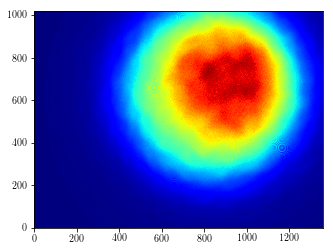

In [29]:
plt.imshow(Raw, cmap=plt.cm.jet, origin='bottom')
plt.show()

[ 19778      0      0 -20726   6449     54      0     40      0   1360
      0  -1024     -1      1     16      0      0      0      0      0
      0      0      0      0      0      0      0]


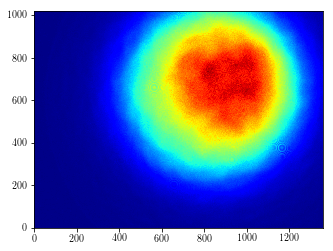

In [1349]:
Raw = np.fromfile('CCD/55/DeviceData_tilt_#001.raw', dtype='int16', sep="")
folder_prefix = "beam_up"
Raw_info = Raw[:27]
print(Raw_info)
Raw = Raw[27:]
Raw=Raw.reshape([1024,1360])
plt.imshow(Raw, cmap=plt.cm.jet, origin='bottom')
plt.show()

In [1350]:
#up 850 down 920 (840 for 6inch) (960 for 218.5)

In [1351]:
I = Raw[(624-400):(624+400),(850-400):(850+400)]

In [1352]:
Iup = I

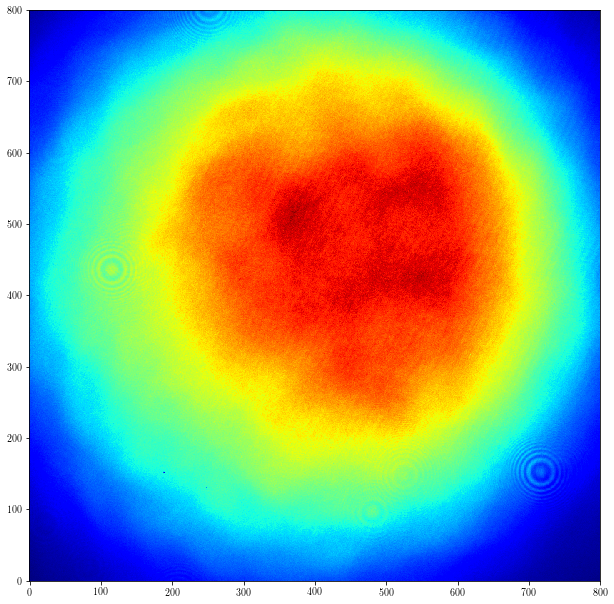

In [1353]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.imshow(I,cmap=plt.cm.jet, origin='bottom')
plt.show()

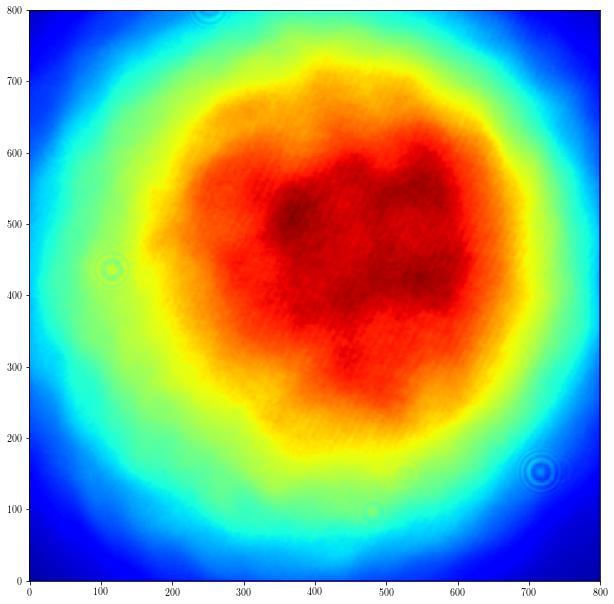

In [1354]:
from scipy import signal
kernel_size = 5
kernel = np.ones([kernel_size,kernel_size])/kernel_size**2
I_new = signal.convolve2d(Iup, kernel, mode = 'same')
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.imshow(I_new,cmap=plt.cm.jet, origin='bottom')
plt.show()

In [1355]:
I = I_new

In [1356]:
dist = (55-32)*0.0254
print(dist)

0.5841999999999999


In [1357]:
beam_info = [np.shape(I)[0],np.shape(I)[1], dist]
Axy = np.sqrt(I)
x = np.arange(np.shape(I)[1])
y = np.arange(np.shape(I)[0])
dx = 6.45e-06
xx, yy = np.meshgrid(x,y)

In [1358]:
def Gaussian2D(x, a, x0, y0, w):
    return a*np.exp(-((x[0]-x0)**2+(x[1]-y0)**2)/w**2)

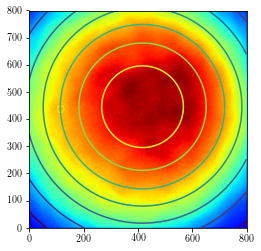

In [1359]:
#Fit to Gaussian
l = 0
xy_list = np.zeros([np.shape(Axy)[0]*np.shape(Axy)[1],2])
Axy_list = np.zeros(np.shape(Axy)[0]*np.shape(Axy)[1])
for i in range(np.shape(Axy)[0]):
    for j in range(np.shape(Axy)[1]):
        xy_list[l] = [xx[i,j], yy[i,j]]
        Axy_list[l] = Axy[i,j]
        l = l+1
xy_list = np.array(xy_list)
initial_guess = (40, 400, 400, 400)
popt, pcov = curve_fit(Gaussian2D, xy_list.transpose(), Axy_list, p0=initial_guess)
Axy_amp = popt[0]
Axy_center = popt[1:3]
Axy_width = popt[3]
fig, ax = plt.subplots(1, 1)
ax.imshow(Axy, cmap=plt.cm.jet, origin='bottom')
ax.contour(Gaussian2D([xx,yy],*popt).reshape(np.shape(Axy)))
plt.show()

In [1360]:
print(Axy_amp)
print(Axy_center[0])
print(Axy_center[1])
print(Axy_width)

48.8688798059
416.657250748
445.639804498
523.250258148


In [1361]:
beam_info.append(dx)
beam_info.append(Axy_amp)
beam_info.append(Axy_center[0])
beam_info.append(Axy_center[1])
beam_info.append(Axy_width)

In [1362]:
beam_info = np.array(beam_info)

In [1363]:
print(beam_info)

[  8.00000000e+02   8.00000000e+02   5.84200000e-01   6.45000000e-06
   4.88688798e+01   4.16657251e+02   4.45639804e+02   5.23250258e+02]


In [1364]:
np.savetxt(folder_prefix+'/beam_info.txt', beam_info)

In [1365]:
Axy = Axy/Axy_amp

In [1366]:
np.max(Axy)

0.96819676146734379

In [1367]:
np.savetxt(folder_prefix+'/beam_amp.txt', Axy)

In [1368]:
#Get phase map
Phasexy = np.zeros([np.shape(Axy)[0]-2,np.shape(Axy)[1]-2])
np.shape(Phasexy)
for i in range(np.shape(Phasexy)[0]):
    for j in range(np.shape(Phasexy)[1]):
        if Axy[i+1,j+1] > 0:
            Phasexy[i,j] = ((Axy[i,j+1]+Axy[i+2,j+1]-2*Axy[i+1,j+1])/dx**2+(Axy[i+1,j]+Axy[i+1,j+2]-2*Axy[i+1,j+1])/dx**2)/Axy[i+1,j+1]/2/k**2

In [1369]:
np.max(Phasexy)

1.0050016547782327e-05

In [1370]:
np.shape(Phasexy)

(798, 798)

In [1371]:
np.savetxt(folder_prefix+'/beam_phase.txt', Phasexy)

In [1372]:
k

7372031.583568204

Beam Down

[ 19778      0      0 -20726   6449     54      0     40      0   1360
      0  -1024     -1      1     16      0      0      0      0      0
      0      0      0      0      0      0      0]


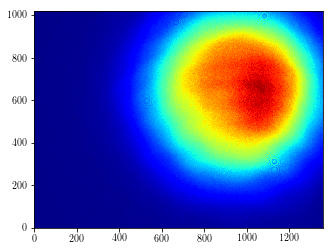

In [1373]:
Raw = np.fromfile('CCD/140.5/DeviceData_newtilt_#002.raw', dtype='int16', sep="")
folder_prefix = "beam_down"
Raw_info = Raw[:27]
print(Raw_info)
Raw = Raw[27:]
Raw=Raw.reshape([1024,1360])
plt.imshow(Raw, cmap=plt.cm.jet, origin='bottom')
plt.show()

In [1374]:
#up 850 down 920 (840 for 6inch) (960 for 218.5)

In [1375]:
I = Raw[(624-400):(624+400),(920-400):(920+400)]

In [1376]:
Idown = I

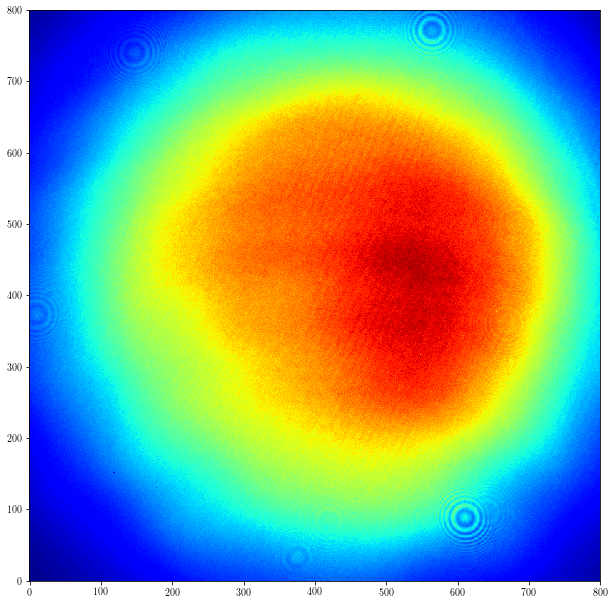

In [1377]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.imshow(I,cmap=plt.cm.jet, origin='bottom')
plt.show()

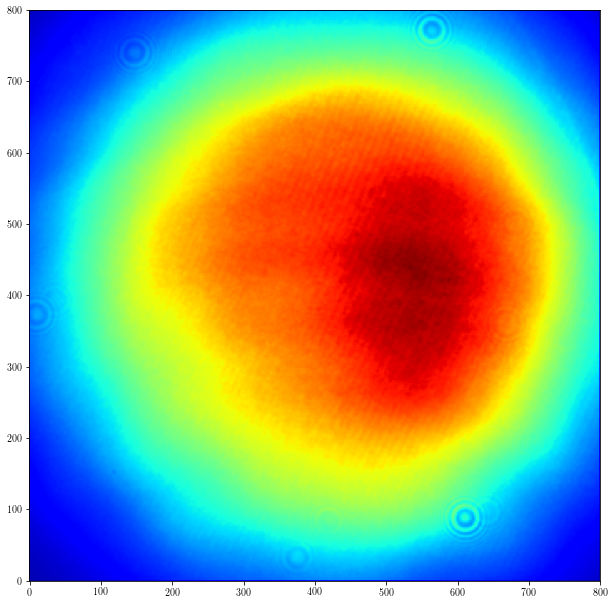

In [1378]:
from scipy import signal
kernel_size = 5
kernel = np.ones([kernel_size,kernel_size])/kernel_size**2
I_new = signal.convolve2d(Idown, kernel, mode = 'same')
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.imshow(I_new,cmap=plt.cm.jet, origin='bottom')
plt.show()

In [1379]:
I = I_new

In [1380]:
dist = (140.5-32)*0.0254
print(dist)

2.7559


In [1381]:
beam_info = [np.shape(I)[0],np.shape(I)[1], dist]
Axy = np.sqrt(I)
x = np.arange(np.shape(I)[1])
y = np.arange(np.shape(I)[0])
dx = 6.45e-06
xx, yy = np.meshgrid(x,y)

In [1382]:
def Gaussian2D(x, a, x0, y0, w):
    return a*np.exp(-((x[0]-x0)**2+(x[1]-y0)**2)/w**2)

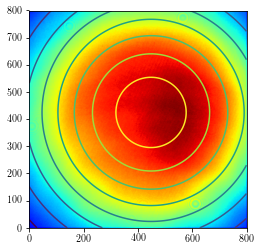

In [1383]:
#Fit to Gaussian
l = 0
xy_list = np.zeros([np.shape(Axy)[0]*np.shape(Axy)[1],2])
Axy_list = np.zeros(np.shape(Axy)[0]*np.shape(Axy)[1])
for i in range(np.shape(Axy)[0]):
    for j in range(np.shape(Axy)[1]):
        xy_list[l] = [xx[i,j], yy[i,j]]
        Axy_list[l] = Axy[i,j]
        l = l+1
xy_list = np.array(xy_list)
initial_guess = (40, 400, 400, 400)
popt, pcov = curve_fit(Gaussian2D, xy_list.transpose(), Axy_list, p0=initial_guess)
Axy_amp = popt[0]
Axy_center = popt[1:3]
Axy_width = popt[3]
fig, ax = plt.subplots(1, 1)
ax.imshow(Axy, cmap=plt.cm.jet, origin='bottom')
ax.contour(Gaussian2D([xx,yy],*popt).reshape(np.shape(Axy)))
plt.show()

In [1384]:
print(Axy_amp)
print(Axy_center[0])
print(Axy_center[1])
print(Axy_width)

42.437662942
447.999515208
424.533842345
531.264373888


In [1385]:
beam_info.append(dx)
beam_info.append(Axy_amp)
beam_info.append(Axy_center[0])
beam_info.append(Axy_center[1])
beam_info.append(Axy_width)

In [1386]:
beam_info = np.array(beam_info)

In [1387]:
print(beam_info)

[  8.00000000e+02   8.00000000e+02   2.75590000e+00   6.45000000e-06
   4.24376629e+01   4.47999515e+02   4.24533842e+02   5.31264374e+02]


In [1388]:
np.savetxt(folder_prefix+'/beam_info.txt', beam_info)

In [1389]:
Axy = Axy/Axy_amp

In [1390]:
np.max(Axy)

0.982501880463999

In [1391]:
np.savetxt(folder_prefix+'/beam_amp.txt', Axy)

In [1392]:
#Get phase map
Phasexy = np.zeros([np.shape(Axy)[0]-2,np.shape(Axy)[1]-2])
np.shape(Phasexy)
for i in range(np.shape(Phasexy)[0]):
    for j in range(np.shape(Phasexy)[1]):
        if Axy[i+1,j+1] > 0:
            Phasexy[i,j] = ((Axy[i,j+1]+Axy[i+2,j+1]-2*Axy[i+1,j+1])/dx**2+(Axy[i+1,j]+Axy[i+1,j+2]-2*Axy[i+1,j+1])/dx**2)/Axy[i+1,j+1]/2/k**2

In [1393]:
np.max(Phasexy)

8.0208215474972759e-06

In [1394]:
np.shape(Phasexy)

(798, 798)

In [1395]:
np.savetxt(folder_prefix+'/beam_phase.txt', Phasexy)

In [1396]:
k

7372031.583568204

# Read Beam Info

In [54]:
Axy_up = np.loadtxt('beam_up/beam_amp.txt')
Axy_down = np.loadtxt('beam_down/beam_amp.txt')
phase2d_up = np.loadtxt('beam_up/beam_phase.txt')
phase2d_down = np.loadtxt('beam_down/beam_phase.txt')
#background = 44.8103

In [55]:
beam_info_up = np.loadtxt('beam_up/beam_info.txt')
beam_info_down = np.loadtxt('beam_down/beam_info.txt')

In [56]:
def Beam_Phase(x, y, z):
    z_up = z
    z_down = ztop*2-z
    #print(z_up, z_down)
    z = z_up
    h = 0.00001
    A0 = Hermite_Gaussian2D([x,y,z],*beam_p)
    Dxx = (Hermite_Gaussian2D([x+h,y,z],*beam_p)+Hermite_Gaussian2D([x-h,y,z],*beam_p)-2*A0)/h**2
    Dyy = (Hermite_Gaussian2D([x,y+h,z],*beam_p)+Hermite_Gaussian2D([x,y-h,z],*beam_p)-2*A0)/h**2
    dk_up = (Dxx+Dyy)/A0/2/k
    z = z_down
    A0 = Hermite_Gaussian2D([x,y,z],*beam_p)
    Dxx = (Hermite_Gaussian2D([x+h,y,z],*beam_p)+Hermite_Gaussian2D([x-h,y,z],*beam_p)-2*A0)/h**2
    Dyy = (Hermite_Gaussian2D([x,y+h,z],*beam_p)+Hermite_Gaussian2D([x,y-h,z],*beam_p)-2*A0)/h**2
    dk_down = (Dxx+Dyy)/A0/2/k
    return dk_up, dk_down

In [73]:
phase2d_up[100,100]

1.0111519098492335e-05

In [74]:
print(beam_info_up)
print(beam_info_down)

[  1.02400000e+03   1.36000000e+03   5.84200000e-01   6.45000000e-06
   6.03257685e+01   6.60786881e+02   5.10857067e+02   4.87527492e+02]
[  1.02400000e+03   1.36000000e+03   2.75590000e+00   6.45000000e-06
   5.88086887e+01   7.40605885e+02   5.30865621e+02   5.11992410e+02]


In [75]:
dx = beam_info_up[3]
#amp_up = beam_info_up[4]
center_up = beam_info_up[5:7]
width_up = beam_info_up[7]
#amp_down = beam_info_down[4]
center_down = beam_info_down[5:7]
width_down = beam_info_down[7]

In [76]:
center_up

array([ 660.78688089,  510.85706712])

In [77]:
print(np.max(Axy_up), np.max(Axy_down))
print(np.max(phase2d_up), np.max(phase2d_down))

1.00913631916 1.02167344093
0.000457703467146 0.000404923220162


In [95]:
def Beam_Amp_Phase(x0, y0):    
    #up
    x = x0/dx+center_up[0]
    y = y0/dx+center_up[1]
    i = int(y)
    j = int(x)
    #print("xyij=",x,y,i,j)
    if i < 2 or j < 2 or i >= np.shape(phase2d_up)[0]-1 or j >= np.shape(phase2d_up)[1]-1:
        phase_up = 0
        amp_up = 0
    else:
        amp0 = Axy_up[i,j]+(Axy_up[i,j+1]-Axy_up[i,j])*(x-j)
        amp1 = Axy_up[i+1,j]+(Axy_up[i+1,j+1]-Axy_up[i+1,j])*(x-j)
        amplitude = amp0+(amp1-amp0)*(y-i)
        x = x-1
        y = y-1
        i = i-1
        j = j-1
        phi0 = phase2d_up[i,j]+(phase2d_up[i,j+1]-phase2d_up[i,j])*(x-j)
        phi1 = phase2d_up[i+1,j]+(phase2d_up[i+1,j+1]-phase2d_up[i+1,j])*(x-j)
        phase = phi0+(phi1-phi0)*(y-i)
        #print(amp0, amp1, phi0, phi1)
        amp_up = amplitude
        phase_up = phase
    #down
    x = x0/dx+center_down[0]
    y = y0/dx+center_down[1]
    i = int(y)
    j = int(x)
    #print("xyij=",x,y,i,j)
    if i < 2 or j < 2 or i >= np.shape(phase2d_down)[0]-1 or j >= np.shape(phase2d_down)[1]-1:
        phase_down = 0
        amp_down = 0
    else:
        amp0 = Axy_down[i,j]+(Axy_down[i,j+1]-Axy_down[i,j])*(x-j)
        amp1 = Axy_down[i+1,j]+(Axy_down[i+1,j+1]-Axy_down[i+1,j])*(x-j)
        amplitude = amp0+(amp1-amp0)*(y-i)
        x = x-1
        y = y-1
        i = i-1
        j = j-1
        phi0 = phase2d_down[i,j]+(phase2d_down[i,j+1]-phase2d_down[i,j])*(x-j)
        phi1 = phase2d_down[i+1,j]+(phase2d_down[i+1,j+1]-phase2d_down[i+1,j])*(x-j)
        phase = phi0+(phi1-phi0)*(y-i)
        #print(amp0, amp1, phi0, phi1)
        amp_down = amplitude
        phase_down = phase
    return amp_up, amp_down, phase_up, phase_down

In [96]:
Beam_Amp_Phase(0,0)

(0.90948153717839275,
 0.91394784109225835,
 -2.9572135720892653e-06,
 -3.4931583844133916e-06)

In [91]:
phase2d_up[510,660]

-3.24648815236711e-06

In [85]:
phase2d_up[510,661]

-7.389335041477628e-07

In [86]:
phase2d_up[510,660]+(phase2d_up[510,661]-phase2d_up[510,660])*(0.786880893)

-1.2733413115299697e-06

In [89]:
x = 659.786880893
y = 509.857067123
i = 509
j = 659

In [90]:
phase2d_up[i,j]+(phase2d_up[i,j+1]-phase2d_up[i,j])*(x-j)

-4.7408530702236997e-06

# Monte Carlo Body

# Parameters

In [62]:
#Laser
Detuning = 14E+9
fL =  3.517309021e+14+90E+6+80E+6+Detuning
c = 2.99792458e+8
k = 2*np.pi*fL/c
hbar = 1.0545718E-34
#Atom distribution
sigma_x = 0.002
sigma_v = 0.0035
kB = 1.38064852e-23
M = 2.20694650e-25
Temperature = sigma_v**2*M/kB
#Atom Interferometer Parameters
t0 = 1.24-1.12
T = 0.060
Tp1 = 0.005
TB = 0.008
Tp2 = 0.015
ztop = 65*0.0254
vr = hbar*k/M
omega_r = hbar*k**2/2/M
n = 5
N = 125
#Atom trajectory
v_2nd_Bragg = 2.0480821101976
g = 9.79958

In [164]:
#Monte Carlo body
#Initialization
size = 5000
t = datetime.datetime.now()
np.random.seed(int(time.mktime(t.timetuple())))
xy_t = np.zeros([size,2])
z_t = np.zeros([size,2])
v_t = np.zeros([size,2])
amp = np.ones([size,2])
phase = np.zeros([size,2])
Bragg_peak_rel = 2.15
Bloch_peak_rel = 0.28
xc = np.array([0, 0])
vc = np.array([0, 0])
z0 = np.array([0,0])
v0 = np.array([1,1])*(v_2nd_Bragg+g*(1.32-1.12))
for i in range(size):
    if i % 1000 == 0:
        print(i)
    xy_t[i] = np.random.normal(0, sigma_x, 2)+xc
    #xy_t[i] = np.random.uniform(-0.0025,0.0025,2)+xc
    vT = np.random.normal(0, sigma_v, 2)+vc
    xy_t[i] = xy(xy_t[i], vT, 1.32-T-1.12)
    z_t[i] = z(z0, v0, 1.32-T-1.12)
    v_t[i] = v(z0, v0, 1.32-T-1.12)
    #First pulse
    t = -T
    print(t, xy_t[i], z_t[i], vT, v_t[i])
    intensity = Bragg_peak_rel*Hermite_Gaussian2D([xy_t[i,0],xy_t[i,1],z_t[i,0]],*beam_p)*Hermite_Gaussian2D([xy_t[i,0],xy_t[i,1],ztop*2-z_t[i,0]],*beam_p)
    print(intensity)
    amp[i,:] = amp[i,:]*eff0(intensity)*eff1(intensity)
    print(amp[i,:])
    xy_t[i] = xy(xy_t[i], vT, T)
    z_t[i] = z(z_t[i], v_t[i], T)
    v_t[i] = v(z_t[i], v_t[i], T)
    #Second pulse
    t = 0
    print(t, xy_t[i], z_t[i], vT, v_t[i])
    intensity = Bragg_peak_rel*Hermite_Gaussian2D([xy_t[i,0],xy_t[i,1],z_t[i,0]],*beam_p)*Hermite_Gaussian2D([xy_t[i,0],xy_t[i,1],ztop*2-z_t[i,0]],*beam_p)
    amp[i,:] = amp[i,:]*eff0(intensity)*eff1(intensity)
    print(amp[i,:])
    dk_up, dk_down = Beam_Phase(xy_t[i,0], xy_t[i,1], z_t[i,0])
    phase[i,:] = phase[i,:]+2*n**2*(dk_up+dk_down)/k
    xy_t[i] = xy(xy_t[i], vT, Tp1)
    z_t[i] = z(z_t[i], v_t[i], Tp1)
    v_t[i] = v(z_t[i], v_t[i], Tp1)
    #Bloch oscillations
    t = Tp1
    print(t, xy_t[i], z_t[i], vT, v_t[i])
    intensity = Bloch_peak_rel*Hermite_Gaussian2D([xy_t[i,0],xy_t[i,1],z_t[i,0]],*beam_p)*Hermite_Gaussian2D([xy_t[i,0],xy_t[i,1],ztop*2-z_t[i,0]],*beam_p)
    amp[i,:] = amp[i,:]*Blocheff(intensity)
    print(amp[i,:])
    dk_up, dk_down = Beam_Phase(xy_t[i,0], xy_t[i,1], z_t[i,0])
    phase[i,:] = phase[i,:]+4*n*N*(dk_up+dk_down)/k
    xy_t[i] = xy(xy_t[i], vT, Tp2)
    z_t[i,0] = z(z_t[i,0], v_t[i,0]-2*N*vr, Tp2)
    z_t[i,1] = z(z_t[i,1], v_t[i,0]+2*N*vr, Tp2)
    v_t[i,0] = v(z_t[i,0], v_t[i,0]-2*N*vr, Tp2)
    v_t[i,1] = v(z_t[i,1], v_t[i,0]+2*N*vr, Tp2)
    #Third pulse
    t = Tp1+Tp2
    print(t, xy_t[i], z_t[i], vT, v_t[i])
    intensity0 = Bragg_peak_rel*Hermite_Gaussian2D([xy_t[i,0],xy_t[i,1],z_t[i,0]],*beam_p)*Hermite_Gaussian2D([xy_t[i,0],xy_t[i,1],ztop*2-z_t[i,0]],*beam_p)
    amp[i,0] = amp[i,0]*eff0(intensity0)*eff1(intensity0)
    dk_up, dk_down = Beam_Phase(xy_t[i,0], xy_t[i,1], z_t[i,0])
    phase[i,0] = phase[i,0]+2*n**2*(dk_up+dk_down)/k
    intensity1 = Bragg_peak_rel*Hermite_Gaussian2D([xy_t[i,0],xy_t[i,1],z_t[i,1]],*beam_p)*Hermite_Gaussian2D([xy_t[i,0],xy_t[i,1],ztop*2-z_t[i,1]],*beam_p)
    amp[i,1] = amp[i,1]*eff0(intensity1)*eff1(intensity1)
    print(amp[i,:])
    dk_up, dk_down = Beam_Phase(xy_t[i,0], xy_t[i,1], z_t[i,1])
    phase[i,1] = phase[i,1]+2*n**2*(dk_up+dk_down)/k
    xy_t[i] = xy(xy_t[i], vT, T)
    z_t[i,0] = z(z_t[i,0], v_t[i,0]-n*vr, T)
    z_t[i,1] = z(z_t[i,1], v_t[i,0]+n*vr, T)
    v_t[i,0] = v(z_t[i,0], v_t[i,0]-n*vr, T)
    v_t[i,1] = v(z_t[i,1], v_t[i,0]+n*vr, T)
    #Fourth pulse
    t = Tp1+Tp2+T
    print(t, xy_t[i], z_t[i], vT, v_t[i])
    intensity0 = Bragg_peak_rel*Hermite_Gaussian2D([xy_t[i,0],xy_t[i,1],z_t[i,0]],*beam_p)*Hermite_Gaussian2D([xy_t[i,0],xy_t[i,1],ztop*2-z_t[i,0]],*beam_p)
    amp[i,0] = amp[i,0]*eff0(intensity0)*eff1(intensity0)
    dk_up, dk_down = Beam_Phase(xy_t[i,0], xy_t[i,1], z_t[i,0])
    phase[i,0] = phase[i,0]+(4*n**2+4*n*N)*(dk_up+dk_down)/k
    intensity1 = Bragg_peak_rel*Hermite_Gaussian2D([xy_t[i,0],xy_t[i,1],z_t[i,1]],*beam_p)*Hermite_Gaussian2D([xy_t[i,0],xy_t[i,1],ztop*2-z_t[i,1]],*beam_p)
    amp[i,1] = amp[i,1]*eff0(intensity1)*eff1(intensity1)
    dk_up, dk_down = Beam_Phase(xy_t[i,0], xy_t[i,1], z_t[i,1])
    phase[i,1] = phase[i,1]+(4*n**2+4*n*N)*(dk_up+dk_down)/k
    xy_t[i] = xy(xy_t[i], vT, 1.93-1.32-t)
    print(amp[i,:])

0
1000
2000
3000
4000


In [165]:
phase0 = np.average(phase[:,0],weights = amp[:,0])

In [166]:
phase1 = np.average(phase[:,1],weights = amp[:,1])

In [167]:
(phase0)/16/n/(n+N)

-2.9587345114343612e-09

In [168]:
(phase1)/16/n/(n+N)

-2.9589546636304598e-09

In [879]:
np.mean(phase[:,0])

2.8421068043045541e-06

In [880]:
sum(amp[:,0])/size

0.00023020208675660281

In [842]:
sum(amp[:,1])/size

0.00029865053033846414

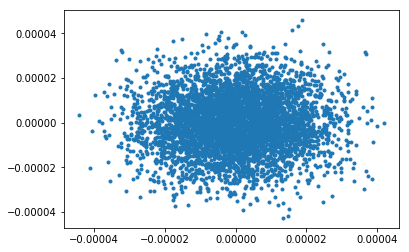

In [843]:
plt.plot(xy_t[:,0],xy_t[:,1],'.')
plt.show()

In [56]:
import Monte_Carlo

ImportError: dynamic module does not define module export function (PyInit_Monte_Carlo)

In [ ]:
Args = {}
Args['size'] = 10000


In [100]:
def Monte_Carlo_CCD(seed):
    #Monte Carlo body CCD
    #Initialization
    size = 10000
    t = datetime.datetime.now()
    #np.random.seed(int(time.mktime(t.timetuple())))
    np.random.seed(seed)
    xy_t = np.zeros([size,2])
    z_t = np.zeros([size,2])
    v_t = np.zeros([size,2])
    amp = np.ones([size,2])
    phase = np.zeros([size,2])
    Bragg_peak_rel = 1.39
    Bloch_peak_rel = 0.28
    xc = np.array([0, 0])
    vc = np.array([0, 0])
    z0 = np.array([0,0])
    v0 = np.array([1,1])*(v_2nd_Bragg+g*(1.32-1.12))
    for i in range(size):
        if i % 1000 == 0:
            print(i)
        xy_t[i] = np.random.normal(0, sigma_x, 2)+xc
        #xy_t[i] = np.random.uniform(-0.0025,0.0025,2)+xc
        vT = np.random.normal(0, sigma_v, 2)+vc
        #print(t, xy_t[i], z_t[i], vT, v_t[i])
        xy_t[i] = xy(xy_t[i], vT, 1.32-T-1.12)
        z_t[i] = z(z0, v0, 1.32-T-1.12)
        v_t[i] = v(z0, v0, 1.32-T-1.12)
        #First pulse
        t = -T
        #print("amp, phase = ", amp[i,0], phase[i,0])
        #print(t, xy_t[i], z_t[i], vT, v_t[i])
        amp_up, amp_down, phase_up, phase_down = Beam_Amp_Phase(xy_t[i,0],xy_t[i,1])
        #print(amp_up, amp_down, phase_up, phase_down)
        intensity = Bragg_peak_rel*amp_up*amp_down
        #print(intensity)
        #print(eff0(intensity))
        amp[i,:] = amp[i,:]*eff0(intensity)*eff1(intensity)
        #print(intensity)
        #print("amp, phase = ", amp[i,0], phase[i,0])
        xy_t[i] = xy(xy_t[i], vT, T)
        z_t[i] = z(z_t[i], v_t[i], T)
        v_t[i] = v(z_t[i], v_t[i], T)
        #Second pulse
        t = 0
        #print(t, xy_t[i], z_t[i], vT, v_t[i])
        amp_up, amp_down, phase_up, phase_down = Beam_Amp_Phase(xy_t[i,0],xy_t[i,1])
        #print(amp_up, amp_down, phase_up, phase_down)
        intensity = Bragg_peak_rel*amp_up*amp_down
        amp[i,:] = amp[i,:]*eff0(intensity)*eff1(intensity)
        #print(intensity)
        #print(eff0(intensity))
        #print(amp[i,:])
        phase[i,:] = phase[i,:]+2*n**2*(phase_up+phase_down)
        xy_t[i] = xy(xy_t[i], vT, Tp1)
        z_t[i] = z(z_t[i], v_t[i], Tp1)
        v_t[i] = v(z_t[i], v_t[i], Tp1)
        #print("amp, phase = ", amp[i,0], phase[i,0])
        #Bloch oscillations
        t = Tp1
        #print(t, xy_t[i], z_t[i], vT, v_t[i])
        amp_up, amp_down, phase_up, phase_down = Beam_Amp_Phase(xy_t[i,0],xy_t[i,1])
        #print(amp_up, amp_down, phase_up, phase_down)
        intensity = Bloch_peak_rel*amp_up*amp_down
        #print(intensity)
        #print(Blocheff(intensity))
        amp[i,:] = amp[i,:]*Blocheff(intensity)
        #print(amp[i,:])
        phase[i,:] = phase[i,:]+4*n*N*(phase_up+phase_down)
        xy_t[i] = xy(xy_t[i], vT, Tp2)
        z_t[i,0] = z(z_t[i,0], v_t[i,0]-2*N*vr, Tp2)
        z_t[i,1] = z(z_t[i,1], v_t[i,0]+2*N*vr, Tp2)
        v_t[i,0] = v(z_t[i,0], v_t[i,0]-2*N*vr, Tp2)
        v_t[i,1] = v(z_t[i,1], v_t[i,0]+2*N*vr, Tp2)
        #print("amp, phase = ", amp[i,0], phase[i,0])
        #Third pulse
        t = Tp1+Tp2
        #print(t, xy_t[i], z_t[i], vT, v_t[i])
        amp_up, amp_down, phase_up, phase_down = Beam_Amp_Phase(xy_t[i,0],xy_t[i,1])
        #print(amp_up, amp_down, phase_up, phase_down)
        intensity0 = Bragg_peak_rel*amp_up*amp_down
        amp[i,0] = amp[i,0]*eff0(intensity0)*eff1(intensity0)
        phase[i,0] = phase[i,0]+2*n**2*(phase_up+phase_down)
        intensity1 = Bragg_peak_rel*amp_up*amp_down
        amp[i,1] = amp[i,1]*eff0(intensity1)*eff1(intensity1)
        #print(intensity0)
        #print(eff0(intensity0))
        #print(amp[i,:])
        phase[i,1] = phase[i,1]+2*n**2*(phase_up+phase_down)
        xy_t[i] = xy(xy_t[i], vT, T)
        z_t[i,0] = z(z_t[i,0], v_t[i,0]-n*vr, T)
        z_t[i,1] = z(z_t[i,1], v_t[i,0]+n*vr, T)
        v_t[i,0] = v(z_t[i,0], v_t[i,0]-n*vr, T)
        v_t[i,1] = v(z_t[i,1], v_t[i,0]+n*vr, T)
        #print("amp, phase = ", amp[i,0], phase[i,0])
        #Fourth pulse
        t = Tp1+Tp2+T
        #print(t, xy_t[i], z_t[i], vT, v_t[i])
        amp_up, amp_down, phase_up, phase_down = Beam_Amp_Phase(xy_t[i,0],xy_t[i,1])
        #print(amp_up, amp_down, phase_up, phase_down)
        intensity0 = Bragg_peak_rel*amp_up*amp_down
        amp[i,0] = amp[i,0]*eff0(intensity0)*eff1(intensity0)
        phase[i,0] = phase[i,0]+(4*n**2+4*n*N)*(phase_up+phase_down)
        intensity1 = Bragg_peak_rel*amp_up*amp_down
        amp[i,1] = amp[i,1]*eff0(intensity1)*eff1(intensity1)
        phase[i,1] = phase[i,1]+(4*n**2+4*n*N)*(phase_up+phase_down)
        xy_t[i] = xy(xy_t[i], vT, 1.93-1.32-t)
        #print(intensity0)
        #print(eff0(intensity0))
        #print(amp[i,:])
        #print("amp, phase = ", amp[i,0], phase[i,0])
        #print("")
    phase0 = np.average(phase[:,0],weights = amp[:,0])
    phase1 = np.average(phase[:,1],weights = amp[:,1])
    return (phase0+phase1)/16/n/(n+N)/2

In [101]:
result = []

In [102]:
for i in range(10):
    print("Atom# = ", i)
    result.append(Monte_Carlo_CCD(i))

Atom# =  0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
Atom# =  1
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
Atom# =  2
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
Atom# =  3
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
Atom# =  4
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
Atom# =  5
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
Atom# =  6
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
Atom# =  7
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
Atom# =  8
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
Atom# =  9
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [103]:
result

[1.1967490614845424e-07,
 2.3779511559247841e-07,
 2.4570111098318755e-07,
 4.7195435684532095e-08,
 1.9853935071416318e-07,
 2.6813104047159557e-07,
 2.9432110012359357e-07,
 1.5366900174415516e-07,
 2.4735529296432783e-07,
 2.7724031899133105e-07]

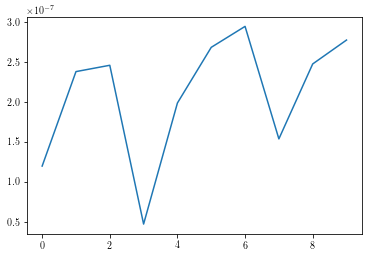

In [104]:
plt.plot(result)
plt.show()

In [105]:
np.mean(result)

2.0896226734178187e-07

In [106]:
np.std(result)/np.sqrt(len(result))

2.3750955702075799e-08

In [241]:
results2 = np.loadtxt('Results.txt')
print(results2)

[  2.38610000e-07   2.38250000e-07   2.04930000e-07   2.57290000e-07
   2.68320000e-07   2.42780000e-07   2.39210000e-07   2.42400000e-07
   2.52700000e-07   2.41070000e-07]


In [242]:
np.mean(results2)

2.4255600000000002e-07

In [217]:
#CCD
up = -8.780012973979071e-10
up_err = 1.5446993234538828e-11
down = -8.1112986672290843e-10
down_err = 2.377348036618565e-12

In [217]:
up = -1.3922318986376083e-09
up_err = 1.3561862472607334e-12
down = -1.4928147749888525e-09
down_err = 1.4483861243003028e-12

In [151]:
result0 = result

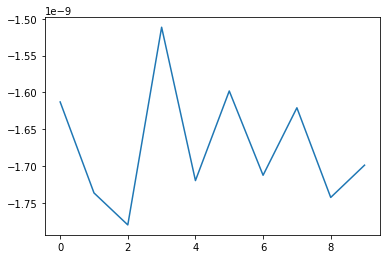

In [119]:
plt.plot(result)
plt.show()

In [120]:
np.mean(result)

-1.6734941116790667e-09

In [123]:
np.std(result)/np.sqrt(len(result))

2.5059071443970562e-11

In [913]:
phase0 = np.average(phase[:,0],weights = amp[:,0])

In [914]:
phase1 = np.average(phase[:,1],weights = amp[:,1])

In [915]:
(phase0+phase1)/16/n/(n+N)/2

2.9211216434368534e-09

In [907]:
result.append((phase0+phase1)/16/n/(n+N)/2)

In [890]:
np.mean(phase2d_in[(254//2-40):(254//2+40),(338//2-40):(338//2+40)])

2.6611350870778141e-09

In [833]:
sum(amp[:,0])/size

0.014990365074474068

In [834]:
sum(amp[:,1])/size

0.014990365074474068

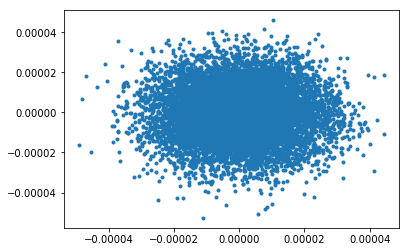

In [835]:
plt.plot(xy_t[:,0],xy_t[:,1],'.')
plt.show()

In [603]:
max(amp[:,0])

0.0012857911439539578

In [268]:
0.0000224918+0.0000233715*0.060

2.389409e-05

In [658]:
x = np.linspace(-0.005,0.005,100)
y = np.linspace(-0.005,0.005,100)
xx, yy = np.meshgrid(x,y)
Ixy = Hermite_Gaussian2D([xx,yy,0.6],*beam_p)*Hermite_Gaussian2D([xx,yy,ztop*2-0.6],*beam_p)
Bragg_eff_xy = eff1(Ixy)**2

In [241]:
x = np.linspace(-0.004,0.004,100)
y = np.linspace(-0.004,0.004,100)
Ixy = np.zeros([100,100])
xx, yy = np.meshgrid(x,y)
for i in range(100):
    for j in range(100):
        amp_up, amp_down, dk_up, dk_down = Beam_Amp_Phase(x[i], y[j])
        Ixy[i,j] = amp_up*amp_down
Bragg_eff_xy = eff1(Ixy)**2

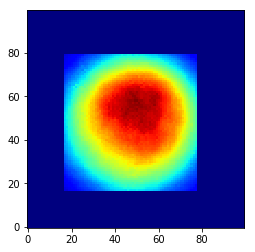

In [242]:
plt.imshow(Ixy, cmap=plt.cm.jet, origin='bottom')
plt.show()

In [243]:
max(Ixy[:,46])

0.91654791661803137

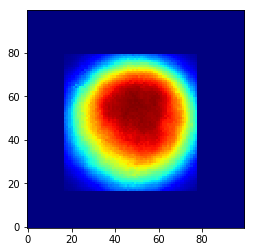

In [246]:
sigma_x = 0.012
Atom = np.exp(-xx**2/sigma_x**2/2-yy**2/sigma_x**2/2)
fig, ax = plt.subplots(1, 1)
ax.imshow(Atom*Raman_eff1(1*Ixy)**2, cmap=plt.cm.jet, origin='bottom')
plt.show()

In [247]:
NewAtom = Atom*Raman_eff1(1*Ixy)**2

In [248]:
contrast_up_xy = np.zeros([100,100])
for i in range(100):
    for j in range(100):
        contrast_up_xy[i,j] = contrast_up(2.15*Ixy[i,j])
sum(map(sum,contrast_up_xy*NewAtom))/sum(map(sum,NewAtom))

0.18945853290612494

In [249]:
def integrated_contrast_up(I0):
    contrast_up_xy = np.zeros([100,100])
    for i in range(100):
        for j in range(100):
            contrast_up_xy[i,j] = contrast_up(I0*Ixy[i,j])
    return sum(map(sum,contrast_up_xy*NewAtom))/sum(map(sum,NewAtom))

In [250]:
def integrated_contrast_down(I0):
    contrast_down_xy = np.zeros([100,100])
    for i in range(100):
        for j in range(100):
            contrast_down_xy[i,j] = contrast_down(I0*Ixy[i,j])
    return sum(map(sum,contrast_down_xy*NewAtom))/sum(map(sum,NewAtom))

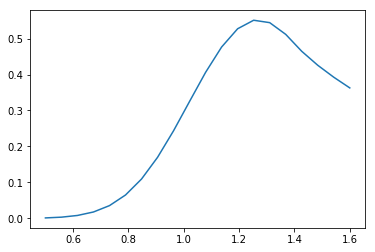

In [251]:
I0_list = np.linspace(0.5,1.6,20)
contrast_up_list = np.zeros(20)
for i in range(20):
    I0 = I0_list[i]
    contrast_up_list[i] = integrated_contrast_up(I0)

plt.plot(I0_list, contrast_up_list)
plt.show()
    

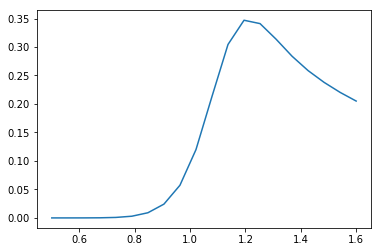

In [252]:
I0_list = np.linspace(0.5,1.6,20)
contrast_down_list = np.zeros(20)
for i in range(20):
    I0 = I0_list[i]
    contrast_down_list[i] = integrated_contrast_down(I0)

plt.plot(I0_list, contrast_down_list)
plt.show()
    

In [668]:
contrast_down_xy = np.zeros([100,100])
for i in range(100):
    for j in range(100):
        contrast_down_xy[i,j] = contrast_down(2*Ixy[i,j])
sum(map(sum,contrast_down_xy*NewAtom))/sum(map(sum,NewAtom))

0.24890058994053674

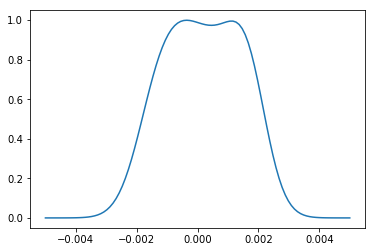

In [661]:
plt.plot(x, (Atom*Raman_eff1(1*Ixy)**2)[50,:])
plt.show()

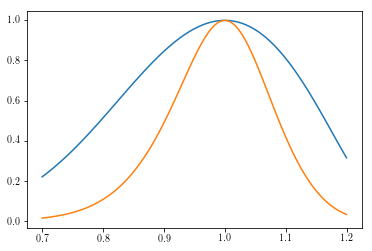

In [448]:
intensity = np.linspace(0.7,1.2,100)
contrast = np.zeros([100,2])
for i in range(100):
    contrast[i,0] = contrast_up(intensity[i])
    contrast[i,1] = contrast_down(intensity[i])
plt.plot(intensity, contrast)
plt.show()

In [654]:
np.zeros([np.shape(Ixy)])

TypeError: an integer is required

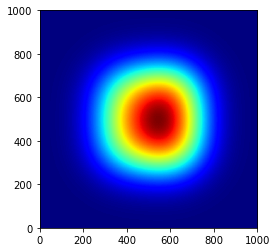

In [517]:
fig, ax = plt.subplots(1, 1)
ax.imshow(Ixy, cmap=plt.cm.jet, origin='bottom')
plt.show()

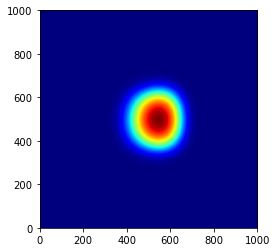

In [518]:
fig, ax = plt.subplots(1, 1)
ax.imshow(Etaxy, cmap=plt.cm.jet, origin='bottom')
plt.show()

In [519]:
np.average(Etaxy,weights = Atom)

0.10445147912201641

In [457]:
0.496**4*0.13305127588179366

0.008052778424967494

In [452]:
eff0(1)

array(0.7046533031803656)

In [ ]:
0
[ 0.425917  0.425917]
[ 0.18140529  0.18140529]
[ 0.02413621  0.02413621]
[ 0.01028002  0.01028002]
[ 0.00437844  0.00437844]

In [526]:
def Raman_eff1(intensity):
    return np.sin(intensity*np.pi)

In [527]:
Raman_EFF_xy = Raman_eff1(Ixy)**2
sigma_x = 0.002
Atom = np.exp(-xx**2/sigma_x**2/2-yy**2/sigma_x**2/2)

In [528]:
np.average(Raman_EFF_xy,weights = Atom)

0.44939499514564951

In [529]:
def transfered(sigma_x, I0):
    Atom = np.exp(-xx**2/sigma_x**2/2-yy**2/sigma_x**2/2)
    Raman_EFF_xy = Raman_eff1(I0*Ixy)**2
    return np.average(Raman_EFF_xy,weights = Atom)

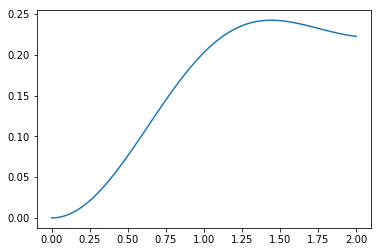

In [537]:
I0_list = np.linspace(0,2,100)
Eff_list = np.zeros(100)
sigma_x = 0.005
for i in range(100):
    I0 = I0_list[i]
    Eff_list[i] = transfered(sigma_x, I0)

plt.plot(I0_list, Eff_list)
plt.show()

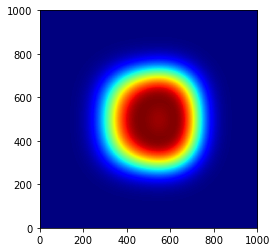

In [577]:
sigma_x = 0.012
Atom = np.exp(-xx**2/sigma_x**2/2-yy**2/sigma_x**2/2)
fig, ax = plt.subplots(1, 1)
ax.imshow(Atom*Raman_eff1(1*Ixy)**2, cmap=plt.cm.jet, origin='bottom')
plt.show()

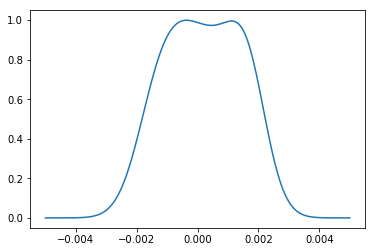

In [578]:
plt.plot(x, (Atom*Raman_eff1(1*Ixy)**2)[500,:])
plt.show()

In [579]:
NewAtom = Atom*Raman_eff1(1*Ixy)**2

In [590]:
np.shape(Ixy)

(1000, 1000)

In [594]:
max(2.5*Ixy[500,:])

1.3785996409057568

In [770]:
Axy_in_center

array([-0.00012616])

In [771]:
Axy_out_center

array([ 0.00040077])

In [365]:
C_results = np.loadtxt("Results.txt")

In [366]:
C_results

array([  1.20990000e-08,   5.47400000e-09,   1.33110000e-08,
         7.25820000e-09,   1.19140000e-08,   1.18470000e-08,
         7.97990000e-09,   1.91210000e-08,   1.13370000e-08,
         5.58520000e-09,   8.69400000e-09,   1.61320000e-08,
         1.83450000e-08,   1.75790000e-08,   1.47290000e-08,
         1.39450000e-08,   1.45600000e-08,   1.67240000e-08,
         7.75550000e-09,   1.87800000e-09,   6.59910000e-09,
         7.71760000e-09,   3.76380000e-09,   9.81690000e-09,
         1.87790000e-08,   7.08920000e-09,   2.63610000e-09,
         1.26560000e-08,   1.76490000e-08,   1.80830000e-08,
         9.11540000e-09,   1.52340000e-08,   7.13730000e-09,
         1.39770000e-08,   1.11110000e-08,   6.94070000e-09,
         8.68500000e-09,   1.09510000e-08,   4.78310000e-09,
         1.28010000e-08,   1.23410000e-08,   1.36130000e-08,
         1.09100000e-08,   1.57240000e-08,   1.59280000e-08,
         1.32230000e-08,   1.30660000e-08,   1.13070000e-08,
         2.23390000e-08,

In [367]:
np.mean(C_results)

1.1071100599999998e-08

In [368]:
np.std(C_results)/np.sqrt(len(C_results))

4.4416728180085079e-10

In [356]:
kernel_size = np.array([1,2,3,4,5,7,10,15,20,30,50,100])
phase = np.array([5.4260799999999988e-08,4.3050341000000005e-09,-8.2686272400000007e-10,-1.7040999999999997e-09,-2.4520125999999997e-09,-2.5085005000000003e-09,-2.7239159999999998e-09,-2.7164599999999995e-09,-2.8099919999999995e-09, -2.7878239999999992e-09, -2.8069049999999998e-09,-2.9185400000000001e-09])
phase_err = np.array([1.2502037749903014e-09,5.5593283940019407e-10,2.6371471120216506e-10,1.7161442872188806e-10,1.1056684986248094e-10,7.5964270076447772e-11,4.4003177901601602e-11,2.2935001853062932e-11,1.546910021171238e-11, 7.4573825327657716e-12, 4.256583459771464e-12,2.3104661867250951e-12])

In [357]:
phase = phase*1e+9

In [358]:
phase_err = phase_err*1e+9

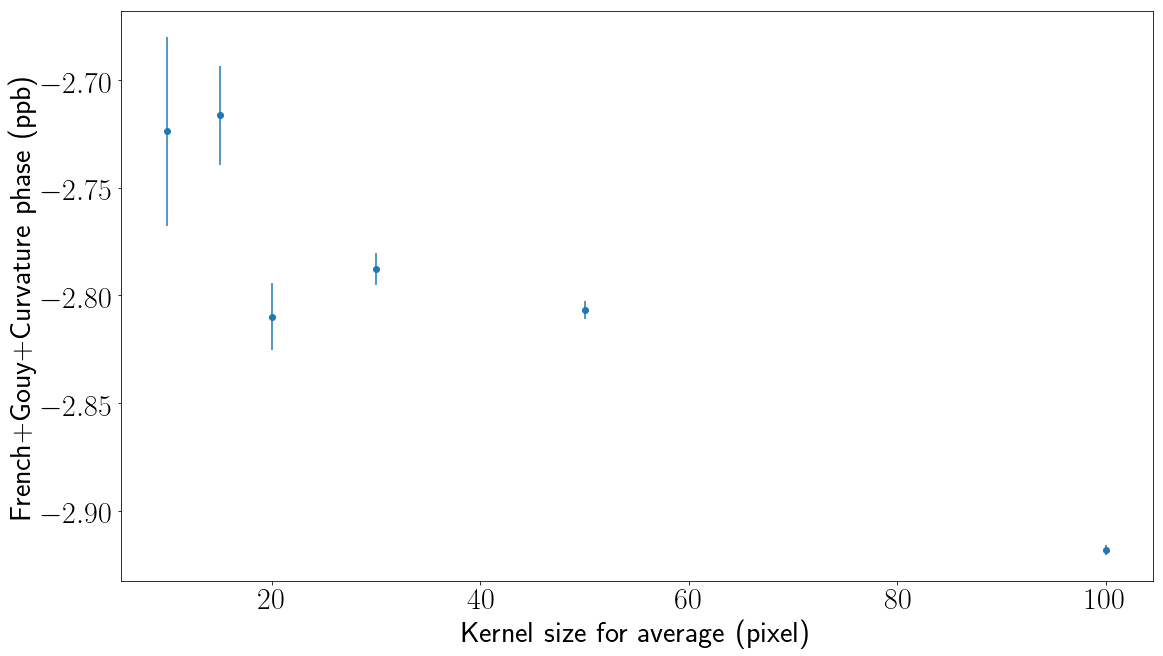

In [360]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
#plt.suptitle("Select alpha measurements", fontsize = 50)
ax.tick_params(axis='both', which='major', labelsize=30)
ax.set_xlabel("Kernel size for average (pixel)", fontsize = 30)
ax.set_ylabel("French+Gouy+Curvature phase (ppb)", fontsize = 30)
plot_handle = ax.errorbar(kernel_size[6:], phase[6:], fmt = 'o', yerr = phase_err[6:])
plt.savefig('phase plot.pdf')
plt.show()
plt.close(fig)

In [317]:
phase_sample = np.loadtxt("phase_out.txt")
amp_sample = np.loadtxt("amp_out.txt")

In [318]:
np.shape(amp_sample)

(200000,)

In [319]:
for i in range(100):
    print(amp_sample[i],phase_sample[i])

0.0 0.0
4.85673e-05 -0.0050817273
6.18e-08 0.0161424983
0.0 0.0
0.0 0.0
0.0006417924 -0.0200946984
0.0003038612 0.0068536104
0.0 0.0
0.0003129538 0.0066528227
0.0008359397 -0.0179588645
0.0009126574 -0.0004077387
0.0 0.0
0.0012763958 -0.0155531742
1.58768e-05 0.00706629
0.0 -0.0058506271
0.0 0.0
0.0 0.0
5.06898e-05 -0.0063901791
2.24688e-05 0.0111450858
5.377e-07 -0.0031146426
0.0001343661 0.0006451121
0.0 0.0
0.0 0.0
6.5176e-06 -0.0243333358
0.0 0.0
4.88536e-05 -0.0214419567
0.0 0.0
2.25642e-05 -0.009744199
0.0005535948 0.0071298241
0.0 0.0
5.2022e-06 -0.0007721932
0.0 0.0
0.0 0.0
0.0 0.0
0.0007265604 0.0121797535
0.0 0.0
0.0005258989 -0.015339145
0.0 0.0
0.0 0.0
0.0003031613 -0.0088736424
0.0006820012 0.0073237554
8.37904e-05 0.0029194237
0.0 0.0026202444
0.0 0.0
4.4054e-06 0.0257037386
2.892e-07 0.0040130579
0.0001223573 -0.0034295777
0.0001166965 0.0506007301
4.07266e-05 -0.0032063757
3.98727e-05 0.0215147533
0.0012907829 0.0049179771
0.0 0.0
0.0005337896 0.0156397394
0.0 -0.010408

In [320]:
np.max(phase_sample)

0.20140307690000001

In [321]:
np.argmax(phase_sample)

21519

In [322]:
amp_sample[21519]

0.00042762280000000001

In [323]:
sample = np.array([amp_sample, phase_sample])

In [324]:
np.shape(sample)

(2, 200000)

In [332]:
arg = np.argsort(amp_sample)

In [346]:
for i in range(500):
    print(amp_sample[arg[-i]], phase_sample[arg[-i]])

0.0 0.0
0.0013240841 -0.001460907
0.0013234177 -0.0031589194
0.0013230315 0.0107884913
0.0013215776 -0.0058920009
0.001321255 -0.0172987969
0.0013200914 -0.0194326069
0.0013198452 0.0045232524
0.0013194615 -0.0337657734
0.0013194202 -0.0029160451
0.0013192082 -0.0070348775
0.0013189818 -0.0203151585
0.0013186871 0.0195721363
0.0013186582 0.0059043466
0.0013181682 -0.0079833847
0.001317409 -0.0088114158
0.0013172235 0.0093951027
0.0013172138 -0.0264063289
0.0013171885 -0.0319211827
0.0013170865 -0.0004568861
0.0013169445 -0.0425768531
0.0013169328 0.0210143803
0.0013166539 -0.0247807944
0.0013162716 -0.0091922331
0.0013162377 -0.0161841283
0.0013161441 0.0276641152
0.0013161404 0.0170688561
0.0013160502 -0.0040906933
0.0013155155 -0.0129033891
0.0013154051 -0.0213377951
0.0013153421 -0.0004835295
0.0013150772 -0.0037402405
0.0013148585 -0.0292971838
0.0013147914 -0.0225617091
0.0013146631 -0.0060643541
0.0013146607 -0.0187971876
0.0013145203 0.0031727367
0.0013145109 -0.0009872504
0.001

In [325]:
ave = np.average(phase_sample, weights = amp_sample)

In [345]:
mean_phase = np.mean(phase_sample[arg[-100:-1]])
mean_amp = np.mean(amp_sample[arg[-100:-1]])
print(mean_amp, mean_phase)

0.00131432681111 -0.00501581438687


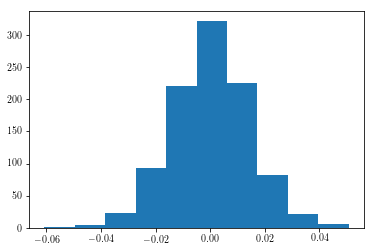

In [354]:
plt.hist(phase_sample[arg[-1000:-1]])
plt.show()

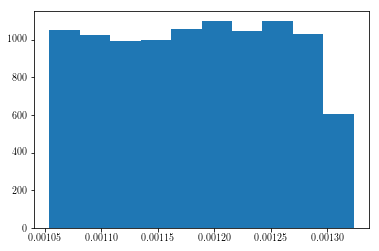

In [351]:
plt.hist(amp_sample[arg[-10000:-1]])
plt.show()

In [438]:
Bloch_data = np.loadtxt("Bloch_power.txt")

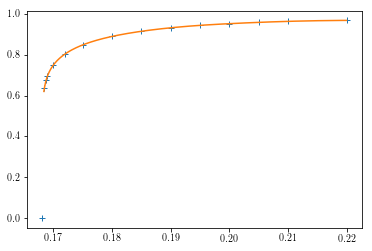

In [439]:
eff_B = interpolate.interp1d(Bloch_data[:,0], (Bloch_data[:,1]), kind = 'cubic')
x = np.linspace(0.1684, 0.22, 500)
y = eff_B(x)
plt.plot(Bloch_data[:,0], Bloch_data[:,1]**0.1, '+', x, y**0.1, '-')
plt.show()

In [440]:
np.shape(Bloch_data)

(15, 2)

In [445]:
contrast_up(1.2431)

0.12186218260563317

In [446]:
contrast_down(1.2431)

0.0040860490268349696